# NEUR-X: A Neural Network Approach to Learning X-ray Source Properties
### Author: Rafael Martinez-Galarza

This notebook presents an early prototype for a neural network tool that learns correlations between Chandra's images of sources and their properties as derived in the Chandra Source Catalog 2.0. The goal is to build a model-independent approach to estimating some of the relevant X-ray properties when only the image of the source and the PSF (or the event file) is availavble. In this initial prototype, a Convolutional Neural Network (CNN) is used to learn simple morphological and photometric properties from cutout images of the source, the PSF in the location of the source, and the exposure map at that location. 

Given that hundreds of thousands of source images are available from the catalog, and that many properties have been carefully estimated for those sources with a forward modeling approach as part of the catalog effort, one could imagine that it would be possible to learn the correlation between the two based on that model-based experience, and use the resulting predictive model to infer properties of sources that have not yet been processes as part of the catalog. This prototype aims at doing just that.

The code uses a TensorFlow-Keras implementation of the CNN, and uses catalog data downloaded from the archive using the CSCview interface. 

In [1]:
# Load required python libraries

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import glob
from astropy.io import fits

## Data loading and visualization
Below is an example of how to load and visualize the input data for the neural network. We use here the regimg3 file, which is a background-subtracted, exposure-corrected image of each source in the catalog as an input, together with the PSF image at the corresponding location, and the exposure map in the same region. One could also add things like the background map, or the pixel mask. The three images enter the model as if they where the three colors of an RGB image, to resemble the way in which color images are fed to a CNN. The idea is that by learning how PSF, exposure, and net count images relate, the model will be able to infer things like the the source extent, the source multiplicity, and the photometry.

One can think of feeding the model also with the images from different bands. But for now, the prototype concentrates on the broad band

In [3]:
hdul = fits.open('/Users/juan/L3/ml_prototype/images/acisf04373_000N021_r0849b_regimg3.fits.gz')
img = hdul[0].data
hdul1 = fits.open('/Users/juan/L3/ml_prototype/images/acisf04373_000N028_r0849b_psf3.fits.gz')
psf = hdul1[0].data
hdul2 = fits.open('/Users/juan/L3/ml_prototype/images/acisf04373_000N022_r0849b_regexp3.fits.gz')
exp = hdul2[0].data

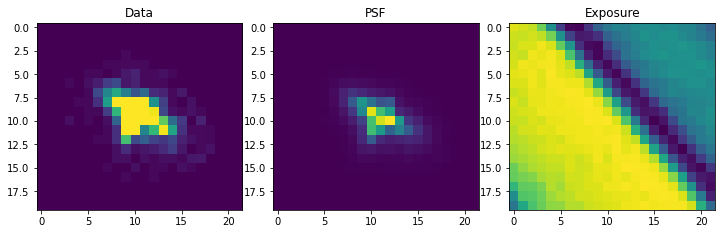

In [6]:
import numpy as np

fig, (ax1, ax2, ax3) =  plt.subplots(figsize=(10,33), ncols=3)
pos1 = ax1.imshow(img)
ax1.set_title('Data')
pos2 = ax2.imshow(psf[int(np.shape(psf)[0]/2)-int(np.shape(img)[0]/2):int(np.shape(psf)[0]/2)+int(np.shape(img)[0]/2),
                     int(np.shape(psf)[1]/2)-int(np.shape(img)[1]/2):int(np.shape(psf)[1]/2)+int(np.shape(img)[1]/2)])
ax2.set_title('PSF')
pos3 = ax3.imshow(exp)
ax3.set_title('Exposure')


plt.tight_layout()
plt.savefig('neurx_fig1.pdf')

We also need to load the table with the properties to be learned. For this example, we load several the observation-level properties associated to each of the observation-level images of the training set. The table was obtained using CSCview, and inlcudes detection coordinates, off-axis angle, counts, fluxes, and source extent parameters. These values constitute the *target* for our learning process

In [5]:
# Read table
import pandas as pd
df = pd.read_csv('/Users/juan/L3/ml_prototype/cscresults4.csv')

In [6]:
# Replace flux nans with zeroes
df['flux_aper_b'] = df['flux_aper_b'].fillna(0)

In [7]:
# Look at extent codes
df['extent_code'].values

array([16, 30, 24, ..., 28,  1,  0])

In [8]:
# See detections for a particular obsid
df.loc[(df['obsid'] == 11997) ]

,obi,obsid,chipx,chipy,chip_id,ra_nom,dec_nom,roll_nom,region_id,theta,...,cnts_aper_b,src_cnts_aper_b,flux_aper_b,cnts_aper90_b,ra_aper90_b,dec_aper90_b,mjr_axis_aper90_b,mnr_axis_aper90_b,pos_angle_aper90_b,area_aper
12648,0,11997,467.545403,323.808504,2,359.992541,-50.133695,32.265004,43,5.944960,...,577,586.684877,1.093804e-13,529,0.114303,-50.072669,3.935530,3.130661,89.790735,106.154440
12649,0,11997,971.330111,582.605968,0,359.992541,-50.133695,32.265004,169,5.413978,...,404,374.345349,4.815573e-14,153,0.129721,-50.153970,4.527995,2.444137,111.059917,154.510183
12650,0,11997,114.926973,275.764215,0,359.992541,-50.133695,32.265004,7,12.551384,...,450,404.094466,1.375765e-13,406,0.282305,-50.230242,17.072211,14.410330,113.449420,1159.044076
12653,0,11997,278.869062,492.329276,3,359.992541,-50.133695,32.265004,30,5.197079,...,1806,1871.602725,3.636116e-13,1690,359.857448,-50.131716,3.102553,2.400865,17.160132,53.017594


In [9]:
df.columns

Index(['obi', 'obsid', 'chipx', 'chipy', 'chip_id', 'ra_nom', 'dec_nom',
       'roll_nom', 'region_id', 'theta', 'phi', 'flux_significance_b',
       'likelihood_b', 'extent_code', 'mjr_axis_raw_b', 'mnr_axis_raw_b',
       'pos_angle_raw_b', 'psf_mjr_axis_raw_b', 'psf_mnr_axis_raw_b',
       'major_axis_b', 'minor_axis_b', 'pos_angle_b', 'src_area_b',
       'cnts_aper_b', 'src_cnts_aper_b', 'flux_aper_b', 'cnts_aper90_b',
       'ra_aper90_b', 'dec_aper90_b', 'mjr_axis_aper90_b', 'mnr_axis_aper90_b',
       'pos_angle_aper90_b', 'area_aper'],
      dtype='object')

## Create the training and test sets
The input to the CNN should be a set of image arrays (X), which has dimenisons (# of examples, # of images per example, # dim1 of the image, # dim 2 of the image), and a set of labels  (y), which contains the target values on which the CNN will be trained. The latter is typically a one-dimensional array containing the quantity to be predicted for each example in the training/test set. Below, for example, we use the off-axis angle. While this is a property that can be directly measured from the detector, is is not among the most impressive properties to predict, but it serves for illustrative purposes (it is also an easy case, as the off-axis angle is closely related to the shape of the PSF).

The input images should al be of the same dimension. So below we apply some padding and trimming to make sure that all the images have the same size (they should also be binned to the same spatial scale). One very important aspect of CNNs is that they are invariant to scale and rotation, which means that it should not matter if some PSFs are larger than others, or oriented differently, the CNN should still recognize aspects like their ellipticity, etc.

In [10]:
# This creates a list of pairs (obsid, region_id), which will be used to select the corresponding images of each type
dets = []
for file in glob.glob('/Users/juan/L3/ml_prototype/images/*regimg3*'):
    hdul = fits.open(file)
    hdul[0].header['REGIONID']
    dets.append(list([file.split('_')[1][-5:],hdul[0].header['REGIONID']]))

In [11]:
# Length of the array (total number of examples), and one example
print(len(dets))
print(dets[0])

13323
['04501', '0840']


In [12]:
# Now we iterate over examples and create the X and y arrays by reading from the images and the properties table

# Placeholders for X and y
X = []
y = []

# Loop over examples
for j in range(len(dets)):
    try:       
        # Split files into count images, PSFs, and exposire maps
        for i,file in enumerate(glob.glob('/Users/juan/L3/ml_prototype/images/*'
                                          +dets[j][0]+'*'+dets[j][1]+'*')):

            if (file.split('_')[4][0:5] == 'regim'):
                hdul = fits.open(file)
                img = hdul[0].data

            elif (file.split('_')[4][0:5] == 'psf3.'):
                hdul = fits.open(file)
                psf = hdul[0].data

            else:
                hdul = fits.open(file)
                exp = hdul[0].data

        # Make sure all images have even dimensions        
        if (np.shape(img)[0]%2 != 0):
            img = img[0:-1,:]
            exp = exp[0:-1,:]
        if (np.shape(img)[1]%2 != 0):
            img = img[:,0:-1]
            exp = exp[:,0:-1]   
        
        # Decide the dimension of the square images, in order to apply padding to those that are smaller
        side = 30
    
        # Pad and trim when necessary, to get all images to be of the same dimension
        if ((np.shape(img)[0] <= side) & (np.shape(img)[1] <= side) & (np.shape(img) == np.shape(exp)) & (np.shape(img) == 
                                                            np.shape(psf[int(np.shape(psf)[0]/2)
                                                             -int(np.shape(img)[0]/2):int(np.shape(psf)[0]/2)
                                                             +int(np.shape(img)[0]/2),int(np.shape(psf)[1]/2)
                                                             -int(np.shape(img)[1]/2):int(np.shape(psf)[1]/2)
                                                             +int(np.shape(img)[1]/2)]))):
        
               
            img = np.pad(img, ((int((side-np.shape(img)[0])/2),int((side-np.shape(img)[0])/2)), 
                                (int((side-np.shape(img)[1])/2),int((side-np.shape(img)[1])/2))), 'constant')
        

            psf = np.pad(psf, ((int((side-np.shape(img)[0])/2),int((side-np.shape(img)[0])/2)), 
                                (int((side-np.shape(img)[1])/2),int((side-np.shape(img)[1])/2))), 'constant')
        
            exp = np.pad(exp, ((int((side-np.shape(exp)[0])/2),int((side-np.shape(exp)[0])/2)), 
                                (int((side-np.shape(exp)[1])/2),int((side-np.shape(exp)[1])/2))), 'constant')
        
        
        
        
            psf = psf[int(np.shape(psf)[0]/2)-int(np.shape(img)[0]/2):int(np.shape(psf)[0]/2)+int(np.shape(img)[0]/2),
                            int(np.shape(psf)[1]/2)-int(np.shape(img)[1]/2):int(np.shape(psf)[1]/2)+int(np.shape(img)[1]/2)]
        
    
            # For some reason example 3319  is problematic. For all the rest, append images and target value 
            # to X and y respectively
            if (j != 3319):
                X.append([img.reshape(side,side),psf.reshape(side,side),exp.reshape(side,side)])
                y.append((df.loc[(df['obsid'] == int(dets[j][0])) & (df['region_id'] == int(dets[j][1]))]['extent_code'].values[0]))
            print(np.shape(X),np.shape(y))
            
    except:
        continue

(1, 3, 30, 30) (1,)
(2, 3, 30, 30) (2,)
(3, 3, 30, 30) (3,)
(4, 3, 30, 30) (4,)
(5, 3, 30, 30) (5,)
(6, 3, 30, 30) (6,)
(7, 3, 30, 30) (7,)
(8, 3, 30, 30) (8,)
(9, 3, 30, 30) (9,)
(10, 3, 30, 30) (10,)
(11, 3, 30, 30) (11,)
(12, 3, 30, 30) (12,)
(13, 3, 30, 30) (13,)
(14, 3, 30, 30) (14,)
(15, 3, 30, 30) (15,)
(16, 3, 30, 30) (16,)
(17, 3, 30, 30) (17,)
(18, 3, 30, 30) (18,)
(19, 3, 30, 30) (19,)
(20, 3, 30, 30) (20,)
(21, 3, 30, 30) (21,)
(22, 3, 30, 30) (22,)
(23, 3, 30, 30) (23,)
(24, 3, 30, 30) (24,)
(25, 3, 30, 30) (25,)
(26, 3, 30, 30) (26,)
(27, 3, 30, 30) (27,)
(28, 3, 30, 30) (28,)
(29, 3, 30, 30) (29,)
(30, 3, 30, 30) (30,)
(31, 3, 30, 30) (31,)
(32, 3, 30, 30) (32,)
(33, 3, 30, 30) (33,)
(34, 3, 30, 30) (34,)
(35, 3, 30, 30) (35,)
(36, 3, 30, 30) (36,)
(37, 3, 30, 30) (37,)
(38, 3, 30, 30) (38,)
(39, 3, 30, 30) (39,)
(40, 3, 30, 30) (40,)
(41, 3, 30, 30) (41,)
(42, 3, 30, 30) (42,)
(43, 3, 30, 30) (43,)
(44, 3, 30, 30) (44,)
(45, 3, 30, 30) (45,)
(46, 3, 30, 30) (46,)
(47, 3

In [13]:
# Final shape of the data set.
print(np.shape(X))
print(np.shape(y))

(6151, 3, 30, 30)
(6151,)


In [14]:
# Save arrays, so you don't need to recompute them later.
np.save('training_data_extent_code.npy',X)
np.save('test_data_extent_code.npy',y)

In [89]:
# Load arrays again (You can start here after having constructed the arrays)
X2 = np.load('training_data_extent_code.npy')
y2 = np.load('test_data_extent_code.npy')

In [90]:
y = y2[~np.isnan(y2)]
X = X2[~np.isnan(y2),:,:,:]

In [91]:
print(np.shape(X))
print(np.shape(y))

(6151, 3, 30, 30)
(6151,)


1
16
8
0
16


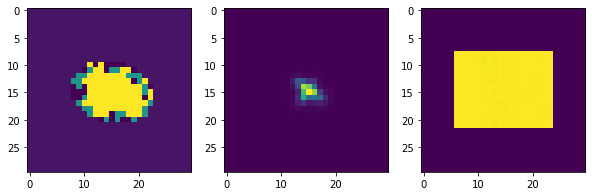

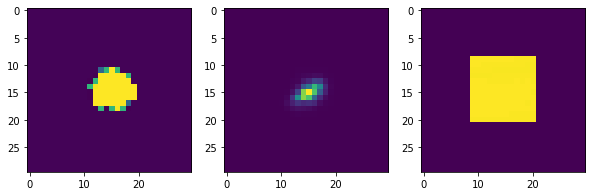

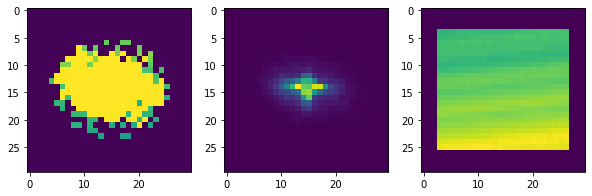

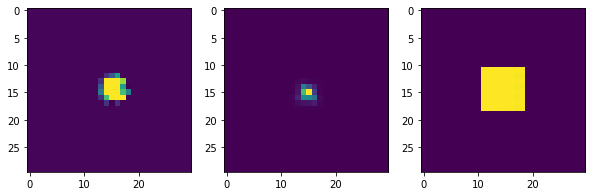

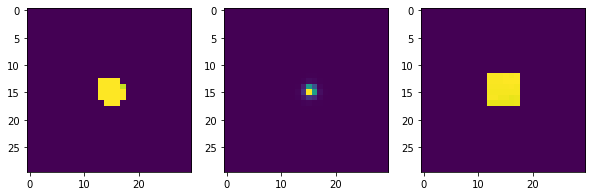

In [92]:
# Visualize a few examples of the dataset
for h in range(5,10):
    print(y[h])
    fig =  plt.subplots(figsize=(10,33))
    plt.subplot(1,3,1)
    plt.imshow(X[h][0])
    plt.subplot(1,3,2)
    plt.imshow(X[h][1])
    plt.subplot(1,3,3)
    plt.imshow(X[h][2])

## Splitting the dataset into training set and test (validation) set
In order for the CNN to be trained, you need to separate a fraction of the examples to perform the training, and another fraction to check on the level of accuray of the predictions as the training progresses. The first set is called the training set (and it is usually the 80% of the examples), whereas the remianing 20% is used for validation. As the training progresses, we check on the validation error of the predictions in order to see if we are in fact improving in our prediction.

In [93]:
# Convert arrays to numpy arrays

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

y1 = y
y1[np.where(y1==16)] = 1
y1[np.where(y1>1)] = 0


# Reorder the dimensions, so that the input is properly processed by the CNN
X1 = np.transpose(X, (0, 2, 3, 1))

# Split into training and test sets
train_images = X1[0:4920]
train_labels = y1[0:4920]
test_images = X1[4920:]
test_labels = y1[4920:]

# Normalize the input. This makes it easier for the CNN to interpret it.
train_images, test_images = train_images / np.max(X1), test_images / np.max(X1)

# Read the dimension of the images
side = np.shape(train_images)[1]

In [94]:
# Final dimensions of the training set
np.shape(train_images)

(4920, 30, 30, 3)

In [103]:
test_labels

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [95]:
# There must be as many labels (target values for the prediction) as there are example inputs.
np.shape(train_labels)

(4920,)

# Checking that the training set is representative
It is very important in supervised machine learning to check that the training set is representative of the test on which the predictive model will be applied. Otherwise this becomes a process of "rubish in, rubish out". To check on that, below we show a histogram comparing the distribution of target values between training and test sets.

(array([27.25609614,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  2.74390015]),
 array([0.        , 0.03333334, 0.06666667, 0.1       , 0.13333334,
        0.16666667, 0.2       , 0.23333333, 0.26666668, 0.3       ,
        0.33333334, 0.36666667, 0.4       , 0.43333334, 0.46666667,
        0.5       , 0.53333336, 0.56666666, 0.6       , 0.6333333 ,
        0.6666667 , 0.7       , 0.73333335, 0.76666665, 0.8       ,
        0.8333333 , 0.8666667 , 0.9       , 0.93333334, 0.96666664,
        1.        ], dtype=float32),
 <a list of 30 Patch objects>)

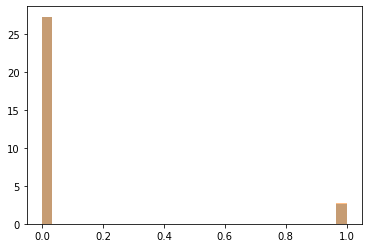

In [96]:
import matplotlib.pyplot as plt
plt.hist(test_labels,bins=30,alpha=0.5,density=1)
plt.hist(train_labels,bins=30,alpha=0.5,density=1)

## Construction the CNN model
Now we construct the CNN. This prototype uses a ver y simple model that uses a single convolutional layer before passing it on to a set of two fully conected dense layers that perform the regression. It can be understood in the following terms: the convolutional layer creates a representation of the data, a set of *feature maps*. These feature maps are the predictors that will be used by the fully connected layers to perform the regression (i.e. the fitting to predict the target quantity, in this case the off-axis angle). The MaxPooling and Dropout layers further simplify the model by reducing the number of parameters.

The model is deliberately simple because the structure of the images is not overly complex. However, there is a lot of room for improvement by carefully tuning the hyperparameters of the CNN. For example, once could add another convolutional layer, or inccrease the number of neurons per layer. Again, this is only a demonstrative prototype so far.

Other important tunable parameters:

* Learning rate: the step size of the jump in stochastic gradient descent when optimizing
* Optimizer: what method is used to optimize the result

**Error measurement:** In order to evaluate the performance of the learning process, at each step we measure the error in the prediction by comparing the predicted value for the test set with the actual, true value (that we have from the beginning, but that the network was see only for the training set). In this cases, this error or loss function is chosen to be the mean square error between the prediction and the true value. But other errors can be used.

**Duration of training:** Each epoch in the model below corresponds to a full forward feeding of the network with all the training data, and the back-propagation of the errors to adjust the model parameters. At the end of each epoch, the prediction error is checked against the test set. As long as this validation error decreases, the model is still learning. If the validation error stops decreasing or even starts increasing, it is time to stop the training (even if the training error is still decreasing), because this means that the model is now overfitting, and becoming to specialized for the trainig set, while losing its ability to generalize to data that it has not seen.

In [97]:
# These layers contruct the representation of the images. The representation (feature maps) 
# are simplified versions of the "data cube" formed by the three images (counts, psg, exposure)
# of each example
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(side, side, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(side, side, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [98]:
# These layers perform the regression to predict the target value.
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(2))

In [99]:
# Here is a summary of the model. 
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [100]:
# Define the optimizer and the learning rate
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [101]:
# Fit the model. We stop at 60 epochs, since that's when the validation error stabilizes.
history = model.fit(train_images, train_labels, epochs=60, 
                    validation_data=(test_images, test_labels))

Epoch 1/60
154/154 [==============================] - 2s 15ms/step - loss: 0.3404 - accuracy: 0.9039 - val_loss: 0.2963 - val_accuracy: 0.9115
Epoch 2/60
154/154 [==============================] - 2s 13ms/step - loss: 0.3109 - accuracy: 0.9085 - val_loss: 0.3005 - val_accuracy: 0.9115
Epoch 3/60
154/154 [==============================] - 2s 14ms/step - loss: 0.3089 - accuracy: 0.9085 - val_loss: 0.3029 - val_accuracy: 0.9115
Epoch 4/60
154/154 [==============================] - 2s 14ms/step - loss: 0.3074 - accuracy: 0.9085 - val_loss: 0.2945 - val_accuracy: 0.9115
Epoch 5/60
154/154 [==============================] - 2s 14ms/step - loss: 0.3054 - accuracy: 0.9085 - val_loss: 0.2954 - val_accuracy: 0.9115
Epoch 6/60
154/154 [==============================] - 2s 13ms/step - loss: 0.3045 - accuracy: 0.9085 - val_loss: 0.2935 - val_accuracy: 0.9115
Epoch 7/60
154/154 [==============================] - 2s 14ms/step - loss: 0.3057 - accuracy: 0.9085 - val_loss: 0.2931 - val_accuracy: 0.9115

39/39 - 0s - loss: 0.2850 - accuracy: 0.9115


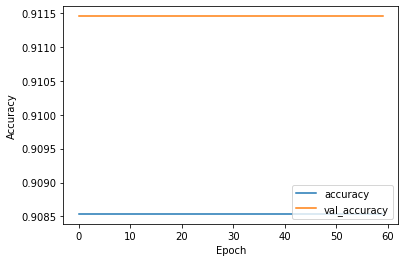

In [74]:
# Plot the validation error (optionally, also the training error)
#plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
#plt.plot(history.history['val_mean_squared_error'], label = 'val_mean_squared_error')
#plt.xlabel('Epoch')
#plt.ylabel('Mean Squared Error')
##plt.ylim([0.5, 1])
#plt.legend(loc='upper right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)



plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [60]:
print(test_acc)

0.9114540815353394


## Checking the predictions
Finally we statistically evaluate the predictions of the trained model. This can be done by comparing the predictions for all of the test set examples with the true value for those same examples. In a classification exercise this would be the confusion matrix, but in this regression example it is just a scatter plot between predicted and true values.

In [58]:
# First print a few predictions
model.predict(test_images)[0:10]

array([[ 1.0479641 , -1.3052113 ],
       [ 0.7325635 , -0.8036828 ],
       [ 0.87750566, -1.0245031 ],
       [ 0.81831753, -0.970421  ],
       [ 0.9494221 , -1.1135905 ],
       [ 0.8527225 , -0.985242  ],
       [ 1.397248  , -1.8293946 ],
       [ 1.0069745 , -1.1753845 ],
       [ 0.80040824, -0.9302788 ],
       [ 0.89985466, -1.048512  ]], dtype=float32)

In [59]:
# And a few true values
test_labels[0:10]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

(-0.9, 0.0)

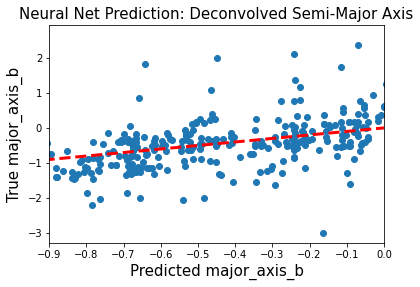

In [32]:
# Now do the scatter plot
plt.scatter(model.predict(test_images)[0:500],test_labels[0:500])
plt.plot(np.linspace(-1,0.2,10),np.linspace(-1,0.2,10),'--',linewidth=3,color='r')
plt.title('Neural Net Prediction: Deconvolved Semi-Major Axis',size=15)
plt.xlabel(r'Predicted major_axis_b',size=15)
plt.ylabel(r'True major_axis_b',size=15)
plt.xlim(-0.9,0.0)
#plt.ylim(-1,8)